In [10]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization,concatenate,UpSampling2D,Dropout
from tensorflow.keras.models import Model
import tensorflow as tf 
from tensorflow.keras.layers import Input, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, Activation, Add, multiply, add, concatenate, LeakyReLU, ZeroPadding2D, UpSampling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K 
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [11]:
mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


In [12]:
X = np.load("../input/teeth-segmentation-npy-files/X.npy")
Y = np.load("../input/teeth-segmentation-npy-files/Y.npy")
X.shape, Y.shape

((464, 512, 512, 1), (464, 512, 512, 1))

In [13]:
# X = np.reshape(X, (-1,1,512,512))
# X.shape
# Y = np.reshape(Y, (-1,1,512,512))
# Y.shape

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=42)

In [15]:
del X
del Y

In [16]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((371, 512, 512, 1), (93, 512, 512, 1), (371, 512, 512, 1), (93, 512, 512, 1))

In [17]:
#### Attention UNet

def conv_block(x, filter_size, size, dropout, batch_norm = False):
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    return conv


def repeat_elem(tensor, rep):
     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': rep})(tensor)


def gating_signal(input, out_size, batch_norm = False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x


def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)
    
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)
    shape_theta_x = K.int_shape(theta_x)

    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(
        inter_shape, 
        (3, 3),
        strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
        padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn



def Attention_UNet():
    # hyper parameters
    dropout_rate = 0.2
    batch_norm = True
    
    # network structure
    f = [16, 32, 64, 128]
    
    inputs = layers.Input(shape = (512, 512, 1))

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, 3, f[0], dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, 3, f[1], dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, 3, f[2], dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 5
    conv_16 = conv_block(pool_16, 3, f[3], dropout_rate, batch_norm)

    # Upsampling layers

    # UpRes 7
    gating_32 = gating_signal(conv_16, f[2], batch_norm)
    att_32 = attention_block(conv_32, gating_32, f[2])
    up_32 = layers.UpSampling2D(size=(2, 2), data_format="channels_last")(conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, 3, f[2], dropout_rate, batch_norm)
    
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, f[1], batch_norm)
    att_64 = attention_block(conv_64, gating_64, f[1])
    up_64 = layers.UpSampling2D(size=(2, 2), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, 3, f[1], dropout_rate, batch_norm)
    
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, f[0], batch_norm)
    att_128 = attention_block(conv_128, gating_128, f[0])
    up_128 = layers.UpSampling2D(size=(2, 2), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, 3, f[0], dropout_rate, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis = 3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = keras.models.Model(inputs, conv_final, name="Attention_UNet")
    return model

model = Attention_UNet()
model.summary()

Model: "Attention_UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 512, 512, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 512, 512, 16) 64          conv2d_30[0][0]                  
__________________________________________________________________________________________________
activation_24 (Activation)      (None, 512, 512, 16) 0           batch_normalization_21[0][0]     
_____________________________________________________________________________________

In [18]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return(2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def IOU(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    
    return intersection/union

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred, 1)

def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())

In [19]:
import tensorflow as tf
model_ckt = tf.keras.callbacks.ModelCheckpoint(
    "./checkpoints/",
    monitor='val_accuracy',
    verbose = 1,
    save_best_only=False,
    save_weights_only=True,
    mode='max',
    save_freq='epoch',
)
learningrate_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                           mode = 'max',
                                                           factor = 0.1, 
                                                           patience = 20, 
                                                           verbose = 1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', 
                                                 patience = 20, 
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                  verbose=1)

callbacks_list = [learningrate_scheduler, early_stopping, model_ckt]

In [20]:
import tensorflow as tf
import tensorflow_addons as tfa
model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate = 0.01), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', dice_coef, IOU, specificity,
                         tf.keras.metrics.Recall(name='recall'),
                         tf.keras.metrics.Precision(name='precision')])

history = model.fit(X_train, Y_train,
          validation_data=(X_test, Y_test),
          batch_size=8,
          epochs=200,
          verbose=1,
          callbacks = callbacks_list)

2022-09-23 16:34:47.914601: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-09-23 16:34:52.903763: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


47/47 [==============================] - 28s 334ms/step - loss: 0.4797 - accuracy: 0.8019 - dice_coef: 0.4484 - IOU: 0.2914 - specificity: 0.8891 - recall: 0.6870 - precision: 0.6843 - val_loss: 19.2063 - val_accuracy: 0.4284 - val_dice_coef: 0.4350 - val_IOU: 0.2785 - val_specificity: 0.3426 - val_recall: 0.9681 - val_precision: 0.3314

Epoch 00001: saving model to ./checkpoints/
Epoch 2/200
47/47 [==============================] - 13s 269ms/step - loss: 0.3097 - accuracy: 0.8648 - dice_coef: 0.5749 - IOU: 0.4042 - specificity: 0.9455 - recall: 0.7879 - precision: 0.8554 - val_loss: 0.3338 - val_accuracy: 0.8229 - val_dice_coef: 0.5736 - val_IOU: 0.4024 - val_specificity: 0.9082 - val_recall: 0.7359 - val_precision: 0.7633

Epoch 00002: saving model to ./checkpoints/
Epoch 3/200
47/47 [==============================] - 13s 268ms/step - loss: 0.2400 - accuracy: 0.8764 - dice_coef: 0.6453 - IOU: 0.4769 - specificity: 0.9618 - recall: 0.7792 - precision: 0.8991 - val_loss: 0.4355 - val_a

In [21]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv("model_history.csv")

In [22]:
hist_df

,loss,accuracy,dice_coef,IOU,specificity,recall,precision,val_loss,val_accuracy,val_dice_coef,val_IOU,val_specificity,val_recall,val_precision,lr
0,0.479680,0.801864,0.448354,0.291428,0.889141,0.687004,0.684305,19.206266,0.428403,0.435048,0.278483,0.342569,0.968141,0.331431,0.01
1,0.309681,0.864850,0.574902,0.404160,0.945486,0.787898,0.855379,0.333831,0.822867,0.573585,0.402443,0.908204,0.735916,0.763303,0.01
2,0.239954,0.876383,0.645330,0.476863,0.961767,0.779157,0.899114,0.435452,0.771947,0.312289,0.185219,0.998212,0.107608,0.971760,0.01
3,0.201779,0.882331,0.694592,0.532572,0.967553,0.783898,0.917279,0.556896,0.756225,0.164675,0.089767,0.999865,0.021478,0.996865,0.01
4,0.177320,0.885438,0.727663,0.572304,0.969689,0.791590,0.924628,0.564859,0.757791,0.168135,0.091821,0.999811,0.029317,0.991888,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,0.051718,0.912299,0.922447,0.856065,0.990694,0.862277,0.987560,0.184255,0.889505,0.857875,0.751808,0.991547,0.737265,0.985312,0.01
90,0.051961,0.912186,0.922270,0.855758,0.990676,0.861323,0.987346,0.127210,0.896293,0.881944,0.789157,0.989858,0.781426,0.983918,0.01
91,0.051138,0.912424,0.923671,0.858174,0.990940,0.861608,0.988016,0.239057,0.882308,0.834591,0.717157,0.990731,0.705515,0.982816,0.01
92,0.050895,0.912487,0.923978,0.858705,0.991000,0.861901,0.988120,0.200875,0.888262,0.856718,0.749989,0.988637,0.747345,0.978866,0.01


In [23]:
idx = hist_df['val_accuracy'].idxmax()
print(idx, hist_df['val_accuracy'][idx])

73 0.9022172689437866


In [24]:
model.save('attn_unet.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [25]:
pred = model.predict(X_test)

In [26]:
from sklearn.metrics import f1_score
import numpy as np

predict_img1=(pred>0.25)*1
y_test1=(Y_test>0.25)*1
f1_score(predict_img1.flatten(), y_test1.flatten(), average='micro')

0.9658144058719758

In [27]:
pred.shape

(93, 512, 512, 1)

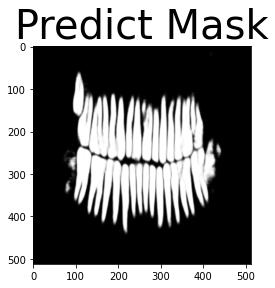

In [28]:
# plt.figure(figsize = (20,10))
plt.title("Predict Mask",fontsize = 40)
plt.imshow(pred[50,:,:,0], cmap='gray')

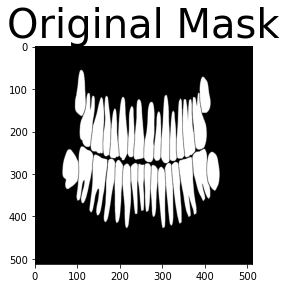

In [29]:
plt.title("Original Mask",fontsize = 40)
plt.imshow(Y_test[50,:,:,0], cmap='gray')